# Thực hành về nhà: Mô hình sinh DCGAN

In [1]:
!nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Fri Oct 24 14:28:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
width = 28
height = 28
channels = 1

<H2>1. Load dữ liệu MNIST</H2>


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.02MB/s]


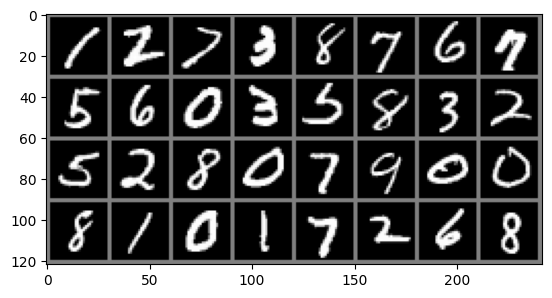

    1     2     7     3     8     7     6     7     5     6     0     3     5     8     3     2     5     2     8     0     7     9     0     0     8     1     0     1     7     2     6     8


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>

Lập trình mạng generator.
    
    + Đầu vào là vector ngẫu nhiên 100 chiều.
    + Đầu ra là một ảnh fake với giá trị pixel trong khoảng [-1, 1].

Các thông số của mạng như sau

- Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
- LeakyReLU(0.2))
- Reshape( [7, 7, 128])
- UpSampling2D(size=(2, 2))
- Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')
- LeakyReLU(0.2)
- UpSampling2D(size=(2, 2))
- Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
- Activation('tanh')



In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*128),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
         Unflatten-3            [-1, 128, 7, 7]               0
          Upsample-4          [-1, 128, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]         204,864
         LeakyReLU-6           [-1, 64, 14, 14]               0
          Upsample-7           [-1, 64, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]           1,601
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 839,937
Trainable params: 839,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.92
Params size (MB): 3.20
Estimated Total Size (MB): 4.13
-------------------------------------------

<H2>4. Discriminator</H2>

Khai báo mạng discriminator

    + Đầu vào là một ảnh 28x28
    + Đầu ra là một xác suất cho ta biết ảnh đấy là real hay fake với giá trị trong miền [0, 1]

Thông số của mạng như sau:

-  Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp)
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Flatten()
-  Dense(1,activation='sigmoid')

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=5, stride=2, padding= 2),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.2),
          nn.Conv2d(64, 128, kernel_size=5, stride=2, padding =2),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.2),
          nn.Flatten(),
          nn.Linear(7*7*128, 1),
          nn.Sigmoid()
        )

    def forward(self, x):
         return self.model(x)

D = Discriminator().cuda()
summary(D, (1, 28, 28), batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
           Dropout-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
-------------------------------------------

<h2>5. GAN model</h2>

Chúng ta ghép hai mạng vào với nhau mang generator trước, mạng disciminator sau

Lập trình hàm để ghép mạng

In [7]:
class dcGAN(nn.Module):
  def __init__(self, generator, discriminator):
    super(dcGAN, self).__init__()
    self.G = Generator()
    self.D = Discriminator()
  def forward(self, x):
    fakei = self.G(x)
    return self.D(fakei)

losses_G = []
losses_D = []
samples = []

In [8]:
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
epochs = 100

In [9]:
# for epoch in range(epochs):
#     for (i, (imgs, _)) in enumerate(trainloader, start=1):
#         # Adversarial ground truths
#         valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
#         fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

#         # Configure input
#         real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

#         # -----------------
#         #  Train Generator
#         # -----------------

#         optimizer_G.zero_grad()

#         # Sample noise as generator input
#         z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

#         # Generate a batch of images
#         gen_imgs = G(z)

#         # Loss measures generator's ability to fool the discriminator

#         ##########################
#         pred_fake = D(gen_imgs)
#         g_loss = criterion(pred_fake, valid)
#         ##########################

#         g_loss.backward()
#         optimizer_G.step()

#         # ---------------------
#         #  Train Discriminator
#         # ---------------------

#         optimizer_D.zero_grad()

#         # Loss measures discriminator's ability to classify real from generated samples

#         ##########################
#         pred_real = D(real_imgs)
#         real_loss = criterion(pred_real, valid)

#         pred_fake = D(gen_imgs.detach())
#         fake_loss = criterion(pred_fake, fake)

#         d_loss = (real_loss + fake_loss) / 2
#         ##########################

#         d_loss.backward()
#         optimizer_D.step()

#         if epoch % 10 == 0 and i == len(trainloader):
#             print(
#                 "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                 % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
#             )

#             losses_G.append(g_loss.item())
#             losses_D.append(d_loss.item())
#             samples.append(gen_imgs)


In [10]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        noise_factor = 0.05
        valid = Variable(
            torch.cuda.FloatTensor(imgs.size(0), 1).uniform_(1.0 - noise_factor, 1.0),
            requires_grad=False,
        )
        fake = Variable(
            torch.cuda.FloatTensor(imgs.size(0), 1).uniform_(0.0, noise_factor),
            requires_grad=False,
        )

        # Configure input
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Predict on real and fake images
        pred_real = D(real_imgs)
        real_loss = criterion(pred_real, valid)

        pred_fake = D(gen_imgs.detach())
        fake_loss = criterion(pred_fake, fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generator tries to fool discriminator
        pred_fake = D(gen_imgs)
        g_loss = criterion(pred_fake, valid)

        g_loss.backward()
        optimizer_G.step()

        # -----------------
        #  Logging
        # -----------------
        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)

/tmp/ipython-input-3329126255.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  torch.cuda.FloatTensor(imgs.size(0), 1).uniform_(1.0 - noise_factor, 1.0),


[Epoch 0/100] [Batch 1875/1875] [D loss: 0.1203] [G loss: 3.4970]
[Epoch 10/100] [Batch 1875/1875] [D loss: 0.1146] [G loss: 3.5613]
[Epoch 20/100] [Batch 1875/1875] [D loss: 0.1286] [G loss: 3.4827]
[Epoch 30/100] [Batch 1875/1875] [D loss: 0.1298] [G loss: 3.4603]
[Epoch 40/100] [Batch 1875/1875] [D loss: 0.1036] [G loss: 3.6932]
[Epoch 50/100] [Batch 1875/1875] [D loss: 0.1122] [G loss: 3.5124]
[Epoch 60/100] [Batch 1875/1875] [D loss: 0.1206] [G loss: 3.6119]
[Epoch 70/100] [Batch 1875/1875] [D loss: 0.1237] [G loss: 3.5524]
[Epoch 80/100] [Batch 1875/1875] [D loss: 0.5873] [G loss: 1.6991]
[Epoch 90/100] [Batch 1875/1875] [D loss: 0.6231] [G loss: 1.6915]


### Vẽ đồ thị loss khi huấn luyện

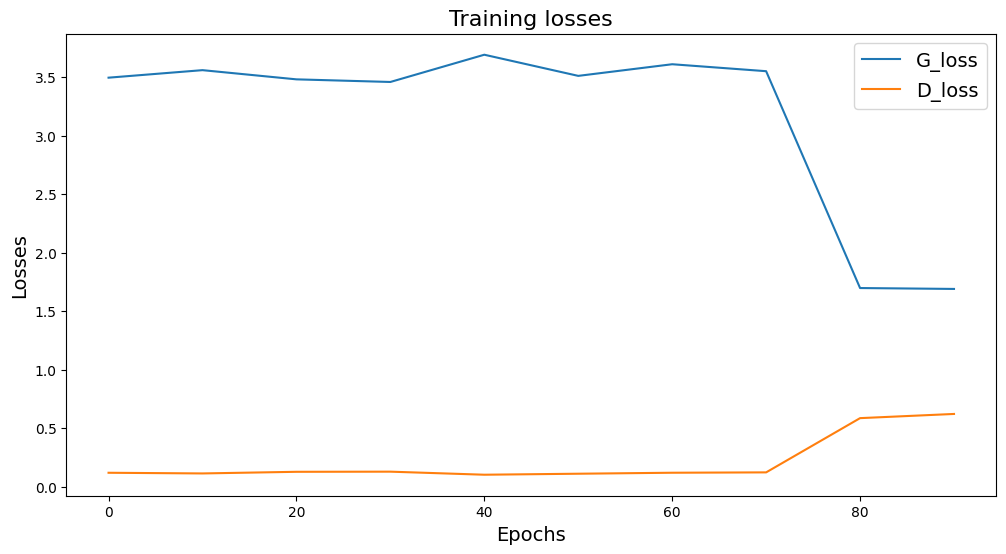

In [11]:
plt.figure(figsize=(12, 6))
epochs_ran = range(0, epochs, 10)
plt.plot(epochs_ran, losses_G, label="G_loss")
plt.plot(epochs_ran, losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Trực quan dữ liệu sinh ra thử mạng học được

    ____________________ Step = 1875 ____________________


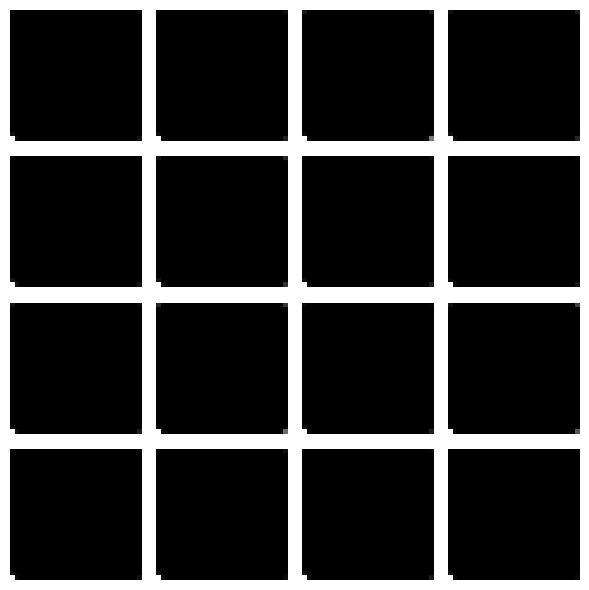



    ____________________ Step = 15 ____________________


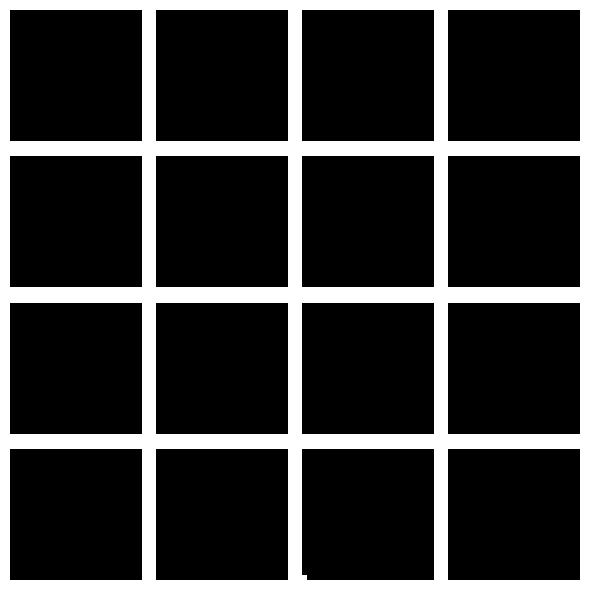



    ____________________ Step = 15 ____________________


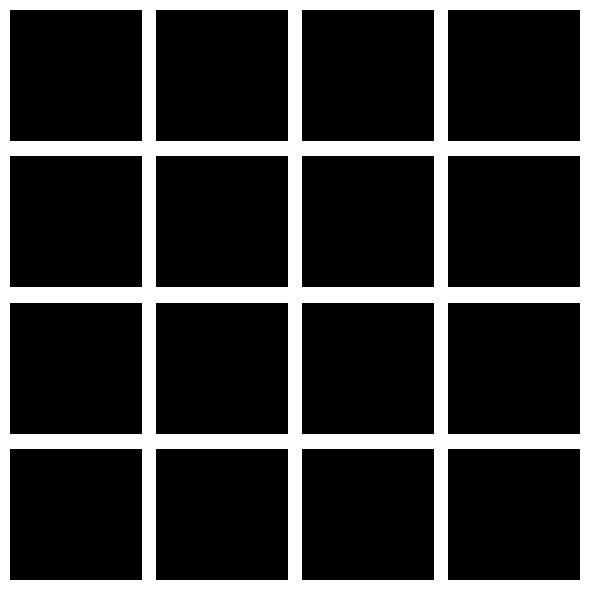



    ____________________ Step = 15 ____________________


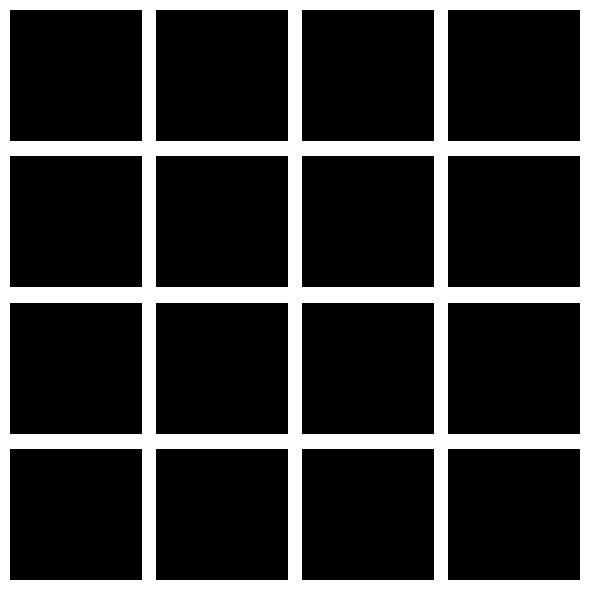



    ____________________ Step = 15 ____________________


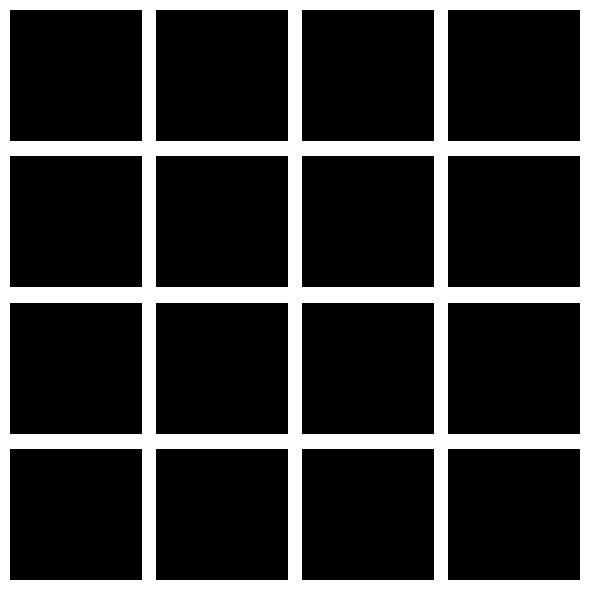



    ____________________ Step = 15 ____________________


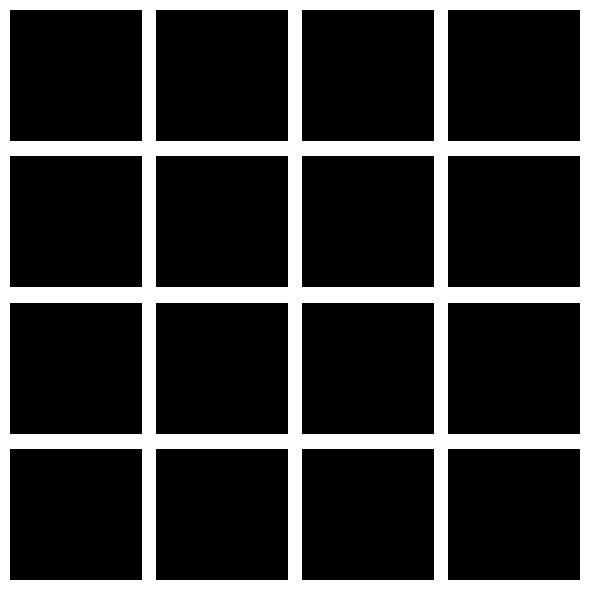



    ____________________ Step = 15 ____________________


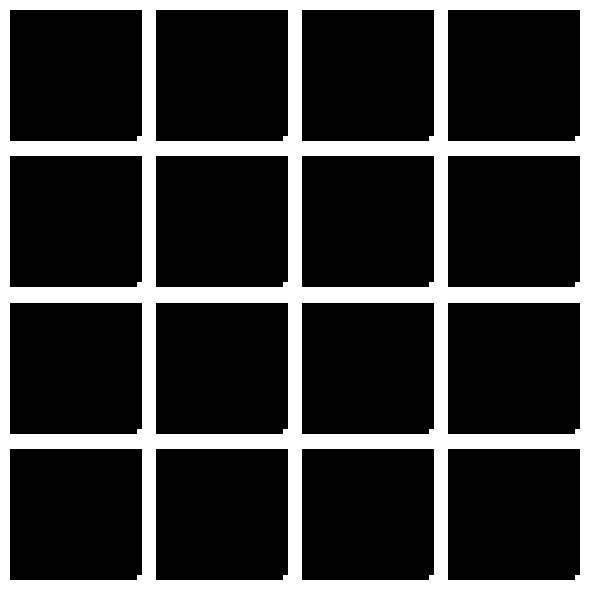



    ____________________ Step = 15 ____________________


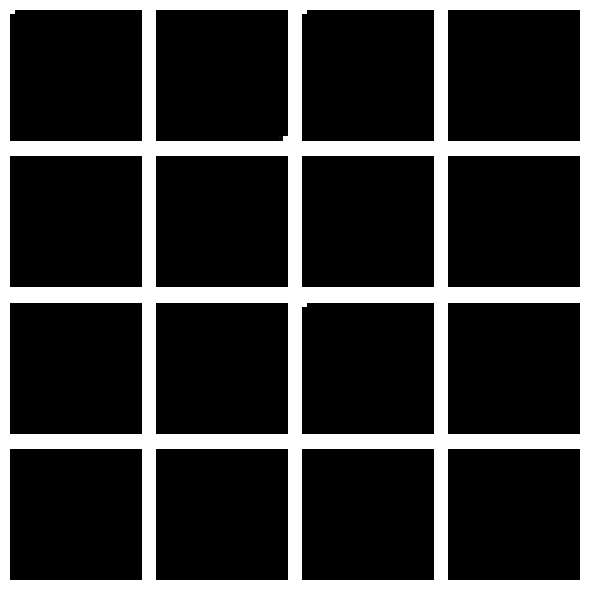



    ____________________ Step = 15 ____________________


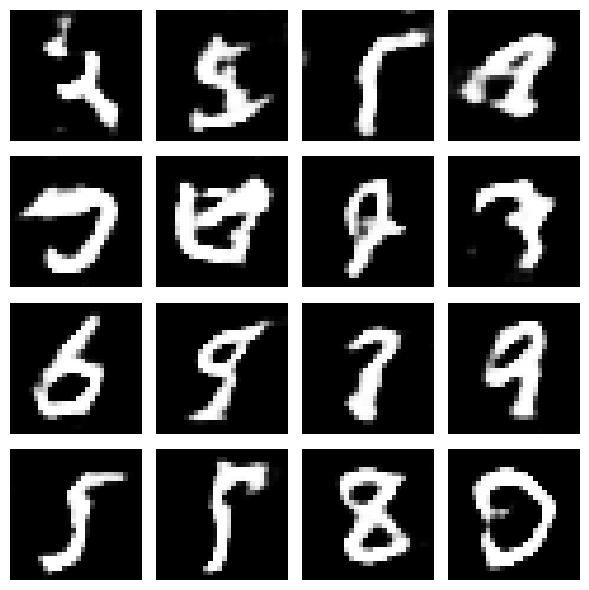



    ____________________ Step = 15 ____________________


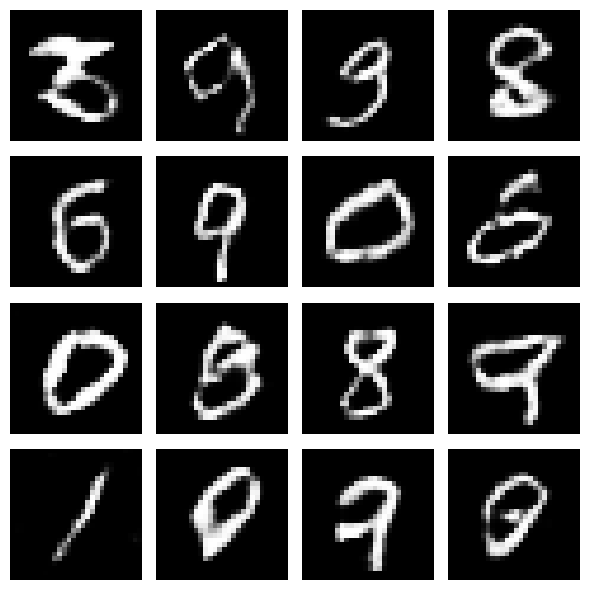

In [12]:
idx = 0
for idx in range(len(samples)):  # Just iterate through all samples
    images = samples[idx].data.cpu().numpy()
    epoch_num = idx * 10
    print("    ____________________ Step = %d ____________________" % i)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")

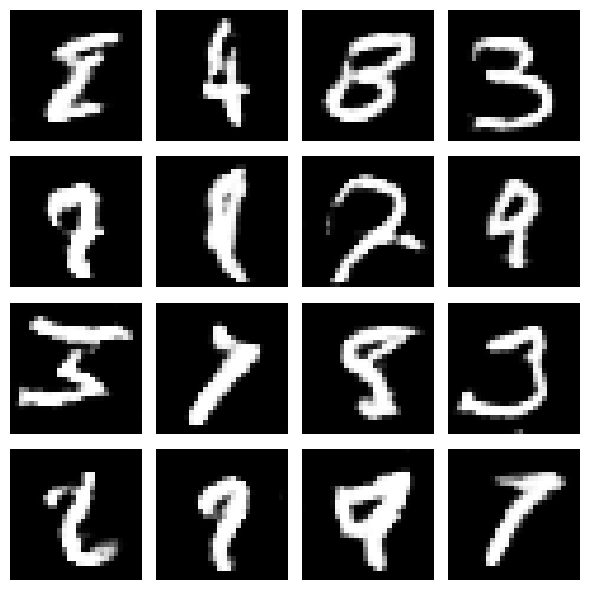

In [13]:
noise = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()